$
\begin{align}
&P(L=l, R=r, V=v, H=h)= \\
&=\begin{cases}
       \sum_{i\in \text{no coal}} & \text{if $l=r$ and $v=h$}\\
    \end{cases}       
\end{align}
$

In [1]:
from IPython.display import SVG
import numpy as np
import pandas as pd
from scipy.linalg import expm
import itertools
%load_ext rpy2.ipython

In [2]:
def recombination(i):
    """
    This function returns all possible states after a 
    single recombination event given an initial state
    """
    # Create empty list
    new_lst = []
    # For each block index in the list
    for block in range(len(i)):
        # If the site is linked
        if 0 not in i[block]:
            # Remove block
            lst = i[:block]+i[block+1:]
            # Split block
            lst = lst + [(i[block][0], 0), (0, i[block][1])]
            # Append to list
            new_lst.append(sorted(lst))
    return new_lst

In [3]:
def coalescent(i):
    """
    This function returns all possible states after a 
    single coalescence event given an initial state. 
    The returned list is somewhat ordered, so that the 
    first states correspond to reversible coalescence 
    events, and the last to non-reversible ones.
    """
    # Get unique values per site
    n_0 = set([0]+list(sum(i, ())))
    reversible = []
    nonreversible = []
    # For each combination of blocks
    for b1 in range(len(i)):
        for b2 in range(b1+1, len(i)):
            # Create new block by merging
            add_lst = [(i[b1][0]+i[b2][0], i[b1][1]+i[b2][1])]
            # For each index in i
            for b3 in range(len(i)):
                # If the index is not in among the merged blocks
                if b3 not in [b1, b2]:
                    # Append to list
                    add_lst.append(i[b3])
            # If the unique values are different from the 
            # original block
            if set([0]+list(sum(add_lst, ()))) == n_0:
                # Append to reversible coalescence list
                reversible.append(sorted(add_lst))
            else:
                # Append to non-reversible coalescence list
                nonreversible.append(sorted(add_lst))
    l = reversible+nonreversible
    return l

In [4]:

def idx(i):
    j = list(sum(i, ()))
    return -(len(j)-j.count(0))

def get_states(lst):
    """
    Given a list of states, this function finds all possible
    recombination and coalescence states iteratively.
    """
    # Sort block per states just in case
    all_states = [sorted(i) for i in lst]
    # Define pool of states to be transformed
    state_pool = all_states
    # While the pool is non-empty
    while len(state_pool) > 0:
        # Define result list per iteration
        iter_states = []
        # For each of the states in the pool
        for i in state_pool:
            # Save coalescent transformation
            iter_states = iter_states+coalescent(i)
            # Save recombination transformation
            iter_states = iter_states+recombination(i)
        # Keep unique values in the original order
        iter_states = sorted(list(list(i) for i in set(tuple(row) for row in iter_states)), key = iter_states.index)
        # Define pool for next round
        state_pool = [i for i in iter_states if i not in all_states]
        # Add pool to overall list
        all_states += state_pool
        
    all_states = sorted(all_states, key = idx)
    return all_states

In [5]:
def iter_lst_to_ggplot(iter_lst_2):
    dat = pd.DataFrame(columns = ['id', 'seg_y', 'seg_xmin', 'seg_xmax', 'dot_color_left', 'dot_color_right'])
    for i in range(len(iter_lst_2)):
        for j in range(len(iter_lst_2[i])):
            if iter_lst_2[i][j][0] == 0:
                xmin = 0
                xmax = 1
                left = '-'
                right = str(iter_lst_2[i][j][1])
            elif iter_lst_2[i][j][1] == 0:
                xmin = -1
                xmax = 0
                left = str(iter_lst_2[i][j][0])
                right = '-'
            else:
                xmin = -1
                xmax = 1
                left = str(iter_lst_2[i][j][0])
                right = str(iter_lst_2[i][j][1])
            dat.loc[len(dat)] = [i, j, xmin, xmax, left, right]
    return dat

In [6]:
%%R

library(tidyverse)

# This function returns a plot of the different states
plot_states <- function(dat) {
    plt <- as_tibble(dat) %>%
        mutate(
            dot_color_left = ifelse(dot_color_left == '-', NA, dot_color_left),
            dot_color_right = ifelse(dot_color_right == '-', NA, dot_color_right)
        ) %>%
        ggplot() +
        geom_segment(aes(x = seg_xmin, xend = seg_xmax,
                         y = seg_y, yend = seg_y)) +
        geom_point(aes(x = seg_xmin, y = seg_y, 
                       color = is.na(dot_color_left), 
                       fill = dot_color_left,
                  shape = dot_color_left == 1),
                  size = 4) +
        geom_point(aes(x = seg_xmax, y = seg_y, 
                       color = is.na(dot_color_right), 
                       fill = dot_color_right,
                   shape = dot_color_right == 1),
                   size = 4) +
        theme_void() +
        facet_wrap(~id, scales = 'free') +
        scale_fill_manual(
            na.value = 'transparent',
            values = c('black', 'white', 'purple', 'yellow', 'orange', 'green', 'black'),
            breaks = as.character(c(1, 2, 3, 4, 5, 6, 7))
        ) +
        scale_color_manual(
            values = c('black', 'transparent')
        ) +
        scale_shape_manual(values=c(24, 21)) +
        scale_x_continuous(expand = c(0.2, 0.2)) +
        scale_y_continuous(expand = c(0.2, 0.2)) +
        theme(legend.position = 'none',
              panel.border = element_rect(colour = "black", fill = NA, size = 1),
              axis.line=element_blank(),
              panel.background=element_blank(),panel.grid.major=element_blank(),
              panel.grid.minor=element_blank(),plot.background=element_blank()) 
    plt
}

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [7]:
def get_trans_mat(iter_lst, coal, rho):
    """
    This function returns a transition matrix given a 
    list of states, a coalescent rate and a recombination
    rate. 
    """
    trans_mat = np.full((len(iter_lst), len(iter_lst)), 0.0)
    for i in range(len(iter_lst)):
        new_lst = recombination(iter_lst[i])
        idx_lst = [iter_lst.index(j) for j in new_lst]
        for j in idx_lst:
            trans_mat[i,j]=rho
        new_lst = coalescent(iter_lst[i])
        idx_lst = [iter_lst.index(j) for j in new_lst]
        for j in idx_lst:
            trans_mat[i,j]=coal
    for i in range(len(iter_lst)):
        trans_mat[i,i]=-sum(trans_mat[i])
    return trans_mat

In [8]:
def combine_states(iter_lst_a, iter_lst_b, probs_a, probs_b):
    """
    Given two lists of states and their probabilities, this
    function returns a list of combined states and their
    probabilities. 
    """
    iter_lst_ab = []
    probs_ab = []
    for i in range(len(iter_lst_a)):
        for j in range(len(iter_lst_b)):
            iter_lst_ab.append(sorted(iter_lst_a[i]+iter_lst_b[j]))
            probs_ab.append(probs_a[i]*probs_b[j])
    return (iter_lst_ab, probs_ab)

# Defining the coalescent hidden Markov model

The idea is to extend Mailund et al. (2011) to model ILS:
1. We will model the divergence of three isolated sequences using a two-nucleotide continuous-time Markov chain (CTMC). 
2. After some time, two of the sequences will be merged and their fate will be model with a two-nucleotide, two-sequence CTMC. The distribution of the starting states will be determined by the individual CTMCs in the previous step.
3. After some time, the resulting sequences will be mixed with the remaining isolated sequence. The starting distribution of the states will be determined by the two-sequence CTMC and the one-sequence CTMC of the last sequence. Now, we will define a discrete Markov jump process, where the states will correspond to either V0 (the coalescence has happened in the previous two-sequence CTMC), or a time-discretized state of other possible coalescences. 

## One-sequence CTMC

We will start by defining a one-sequence, two-nucleotide CTMC. The system will be formed of two possible states, either linked or unlinked:

In [9]:
state_1 = [[(1, 1)]]
iter_lst_1 = get_states(state_1)
iter_lst_1

[[(1, 1)], [(0, 1), (1, 0)]]

Using standard coalescent formulas, we can define the transition rate matrix of the CTMC. As an example, for the sequence tagged as "1", the coalescent rate is 1 and the recombination rate is 2:

In [10]:
coal_1 = 1
rho_1 = 2

state_1 = [[(1, 1)]]
iter_lst_1 = get_states(state_1)
trans_mat_1 = get_trans_mat(iter_lst_1, coal_1, rho_1)
trans_mat_1

array([[-2.,  2.],
       [ 1., -1.]])

The end probabilities can therefore be obtain by matrix exponentiation. For example, for a waiting time of 0.1, and assuming we start in the linked state:

In [11]:
t_1 = 0.1
final_1 = expm(trans_mat_1*t_1)[0]
final_1

array([0.82721215, 0.17278785])

We can do the same for the second sequence, here tagged as "2". Assuming a coalescent rate of 0.5, a recombination rate of 1 and a coalescent time of 0.1 (same as before):

In [12]:
t_2 = t_1
coal_2 = 0.5
rho_2 = 1

state_2 = [[(1, 1)]]
iter_lst_2 = get_states(state_2)
trans_mat_2 = get_trans_mat(iter_lst_2, coal_2, rho_2)
final_2 = expm(trans_mat_2*t_2)[0]
final_2

array([0.90713865, 0.09286135])

## Two-sequence CTMC

We can now define the two-sequence, two-locus CTMC. The simplified rate matrix is first loaded:

In [13]:
%%R -o trans_mat_simple_2_edited -o states_simple_2

# Read he csv file
trans_mat_simple_2 <- read_csv('../02_state_space/trans_mats/trans_mat_simple_2.csv')

# Transform the transition matrix to a spread format
trans_mat_simple_2_edited <- trans_mat_simple_2 %>%
    select(from, to, value)  %>%
    mutate(
        from = as.factor(from), 
        to = as.factor(to)
    ) %>%
    spread(to, value, fill = '0') %>%
    select(-from) %>%
    as.data.frame()

# Save the state names
states_simple_2 <- tibble(
        names = c(trans_mat_simple_2$from_str, trans_mat_simple_2$to_str),
        values = c(trans_mat_simple_2$from, trans_mat_simple_2$to)
    ) %>%
    unique() %>%
    arrange(values) %>%
    as.data.frame()

Rows: 19 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): from_str, to_str, value
dbl (2): from, to

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [14]:
# Transform matrix to Numpy array
trans_mat_simple_2_edited = np.array(trans_mat_simple_2_edited)

In [15]:
def trans_mat_num(trans_mat, coal, rho):
    """
    This function returns a transition matrix given a 
    string matrix whose values are either '0', or 'R'
    or 'C' preceeded by a number, corresponding to a
    multiplication factor for the recombination and 
    the coalescence rate, respectively. The user can
    specify these two numerical rates. The function
    calculates the rates in the diagonals as  
    (-1)*rowSums
    """
    num_rows, num_cols = trans_mat.shape
    trans_mat_num = np.full((num_rows, num_cols), 0.0)
    for i in range(num_rows):
        for j in range(num_cols):
            if trans_mat[i,j] == '0':
                trans_mat_num[i,j] = 0.0
            else:
                trans_mat_num[i,j] = int(trans_mat[i,j][0])*(coal if trans_mat[i,j][1]=='C' else rho)
    for i in range(num_rows):
        trans_mat_num[i,i]=-sum(trans_mat_num[i])
    return trans_mat_num

Given a value for the coalescent and the recombination rates, we can calculate the numerical matrix:

In [16]:
trans_mat_num(trans_mat_simple_2_edited, 1, 2.5)

array([[-6. ,  4. ,  0. ,  1. ,  1. ,  0. ,  0. ,  0. ,  0. ],
       [ 2.5, -5.5,  1. ,  0. ,  0. ,  1. ,  1. ,  0. ,  0. ],
       [ 0. ,  5. , -6. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
       [ 0. ,  0. ,  0. , -3. ,  0. ,  2. ,  0. ,  1. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -3. ,  0. ,  2. ,  1. ,  0. ],
       [ 0. ,  0. ,  0. ,  2.5,  0. , -3.5,  0. ,  0. ,  1. ],
       [ 0. ,  0. ,  0. ,  0. ,  2.5,  0. , -3.5,  0. ,  1. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  1. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  2.5, -2.5]])

We now have all the ingredients for defining the two-sequence, two-locus CTMC. Using the function `combine_states`, we can mix the two one-sequence CTMCs to obtain both the starting states of the new two-sequence CTMC. From them, we can compute the complete state space of this new model, as well as all the starting probabilities:

In [17]:
comb_12 = combine_states(iter_lst_1, iter_lst_2, final_1, final_2)
initial_states_12 = comb_12[0]
iter_lst_12 = get_states(initial_states_12)

Some of the states will be repeated. We can pool their probabilities:

In [18]:
iter_list_inter_12 = comb_12[0]
iter_list_inter_12

[[(1, 1), (1, 1)],
 [(0, 1), (1, 0), (1, 1)],
 [(0, 1), (1, 0), (1, 1)],
 [(0, 1), (0, 1), (1, 0), (1, 0)]]

In [19]:
# Define new data frame
df = pd.DataFrame()
# Save names of state
df['name'] = [str(i) for i in iter_list_inter_12]
# Save probabilities
df['value'] = comb_12[1]
print(df)
# Group by state and sum probabilities
df = df.groupby("name", as_index=False).sum()
print(df)

                               name     value
0                  [(1, 1), (1, 1)]  0.750396
1          [(0, 1), (1, 0), (1, 1)]  0.076816
2          [(0, 1), (1, 0), (1, 1)]  0.156743
3  [(0, 1), (0, 1), (1, 0), (1, 0)]  0.016045
                               name     value
0  [(0, 1), (0, 1), (1, 0), (1, 0)]  0.016045
1          [(0, 1), (1, 0), (1, 1)]  0.233559
2                  [(1, 1), (1, 1)]  0.750396


In [20]:
import ast
# Evaluate string to list
initial_states_12 = [ast.literal_eval(i) for i in list(states_simple_2['names'])]
initial_states_12

[[(0, 1), (0, 1), (1, 0), (1, 0)],
 [(0, 1), (1, 0), (1, 1)],
 [(1, 1), (1, 1)],
 [(0, 2), (1, 0), (1, 0)],
 [(0, 1), (0, 1), (2, 0)],
 [(1, 0), (1, 2)],
 [(0, 1), (2, 1)],
 [(0, 2), (2, 0)],
 [(2, 2)]]

We can create a vector of initial probabilities for the CTMC:

In [21]:
# Create empty vector
pi_12 = []
# For each initial state
for i in list(states_simple_2['names']):
    # If the initial state is in the initial probability dataframe
    if i in df['name'].values:
        # Append probability
        pi_12.append(df['value'][df.index[df['name'] == i].values].values[0])
    # Otherwise
    else:
        # Append 0
        pi_12.append(0.0)
pi_12

[0.01604531311777672,
 0.23355857569326277,
 0.7503961111889603,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

Let's have a look at the initial probabilities:

In [22]:
dat_12 = iter_lst_to_ggplot(initial_states_12)

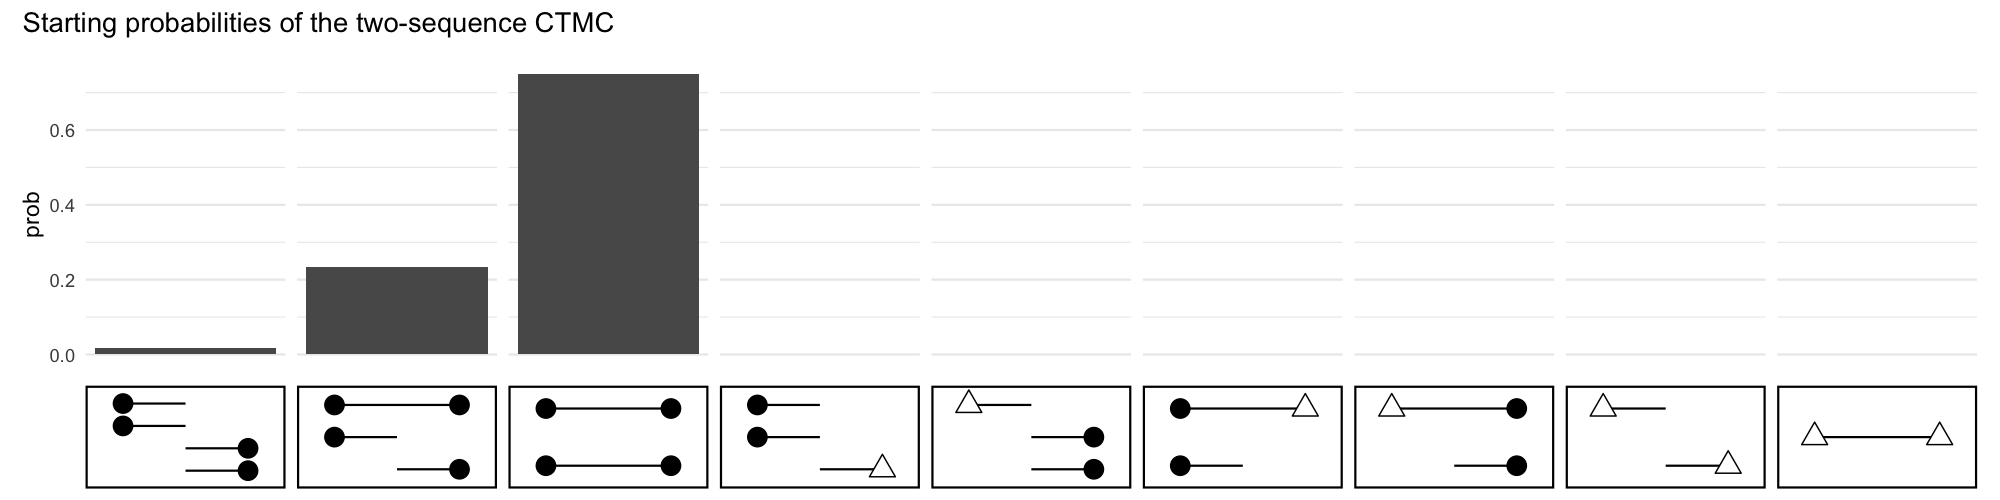

In [23]:
%%R -i pi_12 -i dat_12 -w 2000 -h 500 -r 150

library(patchwork)

p1 <- tibble(id = 0:8, prob = pi_12) %>% 
    ggplot() +
        geom_col(aes(id, prob)) +
        facet_wrap(~id, nrow = 1, scales = 'free_x')+
        theme_minimal() +
        theme(
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.ticks.x=element_blank(),
            strip.background = element_blank(),
            strip.text.x = element_blank(),
            panel.grid.major.x = element_blank(),
            panel.grid.minor.x = element_blank()

        )
p2 <- plot_states(dat_12) +
    facet_wrap(~id, scales = 'free', nrow = 1) +
    theme(
        strip.background = element_blank(),
        strip.text.x = element_blank()

    )

p1/p2 + 
    plot_layout(heights = c(3, 1)) +
    plot_annotation(
        title = 'Starting probabilities of the two-sequence CTMC'
)

We can now define a time interval (for example, 1), a coalescent rate (0.5) and a recombination rate (3) to get the distribution of states at a certain time:

In [24]:
t_12 = 1
coal_12 = 0.5
rho_12 = 3


trans_mat_12 = trans_mat_num(trans_mat_simple_2_edited, coal_12, rho_12)
final_12 = pi_12 @ expm(trans_mat_12*t_12)

In [25]:
final_12

array([0.22336798, 0.15995634, 0.01612736, 0.14469565, 0.14469565,
       0.06238333, 0.06238333, 0.14519001, 0.04120035])

In [33]:
expm(trans_mat_12*t_12)

array([[0.21655433, 0.14279823, 0.012576  , 0.1697218 , 0.1697218 ,
        0.0648803 , 0.0648803 , 0.12719187, 0.03167537],
       [0.21419734, 0.14718366, 0.01369156, 0.16433157, 0.16433157,
        0.06712653, 0.06712653, 0.12668689, 0.03532436],
       [0.22636801, 0.16429868, 0.01696143, 0.1380489 , 0.1380489 ,
        0.06085364, 0.06085364, 0.1513339 , 0.0432329 ],
       [0.        , 0.        , 0.        , 0.45767524, 0.        ,
        0.14885542, 0.        , 0.32935382, 0.06411552],
       [0.        , 0.        , 0.        , 0.        , 0.45767524,
        0.        , 0.14885542, 0.32935382, 0.06411552],
       [0.        , 0.        , 0.        , 0.44656625, 0.        ,
        0.15996441, 0.        , 0.31980962, 0.07365972],
       [0.        , 0.        , 0.        , 0.        , 0.44656625,
        0.        , 0.15996441, 0.31980962, 0.07365972],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.86145677, 0.13854323],


In [299]:
initial_states_12

[[(0, 1), (0, 1), (1, 0), (1, 0)],
 [(0, 1), (1, 0), (1, 1)],
 [(1, 1), (1, 1)],
 [(0, 2), (1, 0), (1, 0)],
 [(0, 1), (0, 1), (2, 0)],
 [(1, 0), (1, 2)],
 [(0, 1), (2, 1)],
 [(0, 2), (2, 0)],
 [(2, 2)]]

In [317]:
flatten = [list(sum(i, ())) for i in initial_states_12]
omega_B = [i for i in range(9) if 2 not in flatten[i]]
omega_L = [i for i in range(9) if (2 in flatten[i][::2]) and (2 not in flatten[i][1::2])]
omega_R = [i for i in range(9) if (2 not in flatten[i][::2]) and (2 in flatten[i][1::2])]
omega_E = [i for i in range(9) if (2 in flatten[i][::2]) and (2 in flatten[i][1::2])]

[7, 8]

In [122]:
def get_pi_ABC(pi_AB, trans_mat, omegas, times):
    pi_ABC = pi_AB @ expm(trans_mat*times[0])[:,omegas[0]]
    for i in range(1, len(omegas)):
        pi_ABC = pi_ABC @ expm(trans_mat*times[i])[omegas[i-1]][:,omegas[i]]
    return np.array([pi_ABC[omegas[len(omegas)-1].index(j)] if j in omegas[len(omegas)-1] else 0 for j in range(9)])

If $L=\text{V0}_l^L, R=\text{V0}_r^R, T_l=T_r$:

In [123]:
get_pi_ABC(pi_12, trans_mat_12, [omega_B, omega_E, omega_E], [0.1, 0.2, 0.3])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01998916, 0.00992419])

If $L=\text{V0}_l^L, R=\text{V0}_r^R, T_l<T_r$:

In [130]:
get_pi_ABC(pi_12, trans_mat_12, [omega_B, omega_L, omega_L, omega_E], [0.1, 0.2, 0.3, 0.4])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00714644, 0.00201327])

If $L=\text{V0}_l^L, R=\text{V0}_r^R, T_l>T_r$:

In [125]:
get_pi_ABC(pi_12, trans_mat_12, [omega_B, omega_R, omega_R, omega_E], [0.1, 0.2, 0.3, 0.4])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00714644, 0.00201327])

If $L=\text{V0}_l^L, R\in\{\text{VM}, \text{V1},\text{V2},\text{V3}\}$:

In [126]:
get_pi_ABC(pi_12, trans_mat_12, [omega_B, omega_L, omega_L], [0.1, 0.2, 0.3])

array([0.        , 0.        , 0.        , 0.        , 0.03326139,
       0.        , 0.01726961, 0.        , 0.        ])

If $L\in\{\text{VM}, \text{V1},\text{V2},\text{V3}\}, R=\text{V0}_r^R$:

In [127]:
get_pi_ABC(pi_12, trans_mat_12, [omega_B, omega_R, omega_R], [0.1, 0.2, 0.3])

array([0.        , 0.        , 0.        , 0.03326139, 0.        ,
       0.01726961, 0.        , 0.        , 0.        ])

If $L\in\{\text{VM},\text{V1},\text{V2},\text{V3}\}, R\in\{\text{VM},\text{V1},\text{V2},\text{V3}\}$:

In [128]:
get_pi_ABC(pi_12, trans_mat_12, [omega_B], [1])

array([0.22336798, 0.15995634, 0.01612736, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [108]:
from scipy.stats import truncexpon

In [285]:
t_AB = 0
t_ABC = 4
coal_AB = 1
n_states_AB = 3
quantiles_AB = np.array(list(range(n_states_AB+1)))/n_states_AB
lower, upper, scale = t_AB, t_ABC, coal_AB
cut_AB = truncexpon.ppf(quantiles_AB, b=(upper-lower)/scale, loc=lower, scale=scale)
cut_AB

array([0.        , 0.39634897, 1.06263599, 4.        ])

In [286]:
tab = np.zeros((n_states_AB*n_states_AB+n_states_AB*2+1, 9))
acc = 0

$L=\text{V0}_l^L, R=\text{V0}_r^R$:

In [287]:
for R in range(len(cut_AB)-1):
    for L in range(len(cut_AB)-1):
        if R == L:
            times = [cut_AB[L]-cut_AB[0], cut_AB[L+1]-cut_AB[L], cut_AB[-1]-cut_AB[L+1]]
            tab[acc] = get_pi_ABC(pi_12, trans_mat_12, [omega_B, omega_E, omega_E], times)
        elif L<R:
            times = [cut_AB[L]-cut_AB[0], cut_AB[L+1]-cut_AB[L], cut_AB[R]-cut_AB[L+1], cut_AB[R+1]-cut_AB[R], cut_AB[-1]-cut_AB[R+1]]
            tab[acc] = get_pi_ABC(pi_12, trans_mat_12, [omega_B, omega_L, omega_L, omega_E, omega_E], times)
        elif L>R:
            times = [cut_AB[R]-cut_AB[0], cut_AB[R+1]-cut_AB[R], cut_AB[L]-cut_AB[R+1], cut_AB[L+1]-cut_AB[L], cut_AB[-1]-cut_AB[L]]
            tab[acc] = get_pi_ABC(pi_12, trans_mat_12, [omega_B, omega_R, omega_R, omega_E, omega_E], times)
        acc += 1

If $L=\text{V0}_l^L, R\in\{\text{VM}, \text{V1},\text{V2},\text{V3}\}$ or $L\in\{\text{VM}, \text{V1},\text{V2},\text{V3}\}, R=\text{V0}_r^R$:

In [288]:
for L in range(len(cut_AB)-1):
    times = [cut_AB[L]-cut_AB[0],cut_AB[L+1]-cut_AB[L],cut_AB[-1]-cut_AB[L+1]]
    tab[acc] = (get_pi_ABC(pi_12, trans_mat_12, [omega_B, omega_L, omega_L], times))
    acc += 1
for R in range(len(cut_AB)-1):
    times = [cut_AB[R]-cut_AB[0],cut_AB[R+1]-cut_AB[R],cut_AB[-1]-cut_AB[R+1]]
    tab[acc] = (get_pi_ABC(pi_12, trans_mat_12, [omega_B, omega_R, omega_R], times))
    acc += 1

If $L\in\{\text{VM},\text{V1},\text{V2},\text{V3}\}, R\in\{\text{VM},\text{V1},\text{V2},\text{V3}\}$:

In [289]:
tab[acc] = get_pi_ABC(pi_12, trans_mat_12, [omega_B], [cut_AB[-1]-cut_AB[0]])

In [298]:
df = pd.DataFrame(tab, columns = [str(i) for i in initial_states_12])
df

,"[(0, 1), (0, 1), (1, 0), (1, 0)]","[(0, 1), (1, 0), (1, 1)]","[(1, 1), (1, 1)]","[(0, 2), (1, 0), (1, 0)]","[(0, 1), (0, 1), (2, 0)]","[(1, 0), (1, 2)]","[(0, 1), (2, 1)]","[(0, 2), (2, 0)]","[(2, 2)]"
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065475,0.010913
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025108,0.004185
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048887,0.008148
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025108,0.004185
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055743,0.009291
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.091100,0.015183
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048582,0.008452
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090532,0.015751
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.189218,0.034447
9,0.000000,0.000000,0.000000,0.000000,0.012794,0.000000,0.004265,0.000000,0.000000


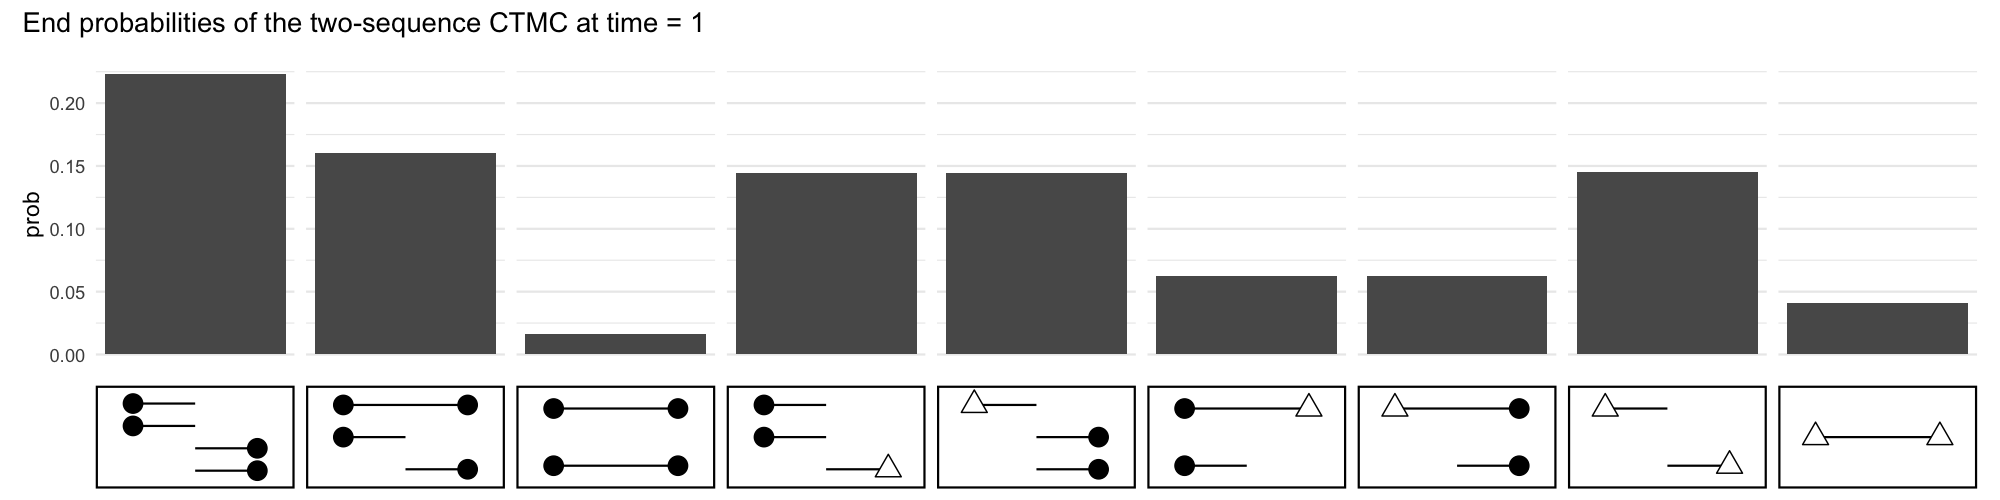

In [38]:
%%R -i final_12 -i dat_12 -w 2000 -h 500 -r 150

library(patchwork)

p1 <- tibble(id = 0:8, prob = final_12) %>% 
    ggplot() +
        geom_col(aes(id, prob)) +
        facet_wrap(~id, nrow = 1, scales = 'free_x')+
        theme_minimal() +
        theme(
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.ticks.x=element_blank(),
            strip.background = element_blank(),
            strip.text.x = element_blank(),
            panel.grid.major.x = element_blank(),
            panel.grid.minor.x = element_blank()

        )
p2 <- plot_states(dat_12)+
    facet_wrap(~id, scales = 'free', nrow = 1) +
    theme(
        strip.background = element_blank(),
        strip.text.x = element_blank()

    )

p1/p2 + plot_layout(heights = c(3, 1)) + 
    plot_layout(heights = c(3, 1)) +
    plot_annotation(
        title = 'End probabilities of the two-sequence CTMC at time = 1'
)

$$
\begin{aligned}
\begin{array}{|c|c|c|c|c|c|c|c|c|c|}
    \hline & V_0^{t=1} & V_0^{t=2} & V_1^{t=I} & V_2^{t=I} & V_3^{t=I} & V_1^{t=II} & V_2^{t=II} & V_3^{t=II}\\
    \hline V_0^{t=1} \\
    \hline V_0^{t=2} \\
    \hline V_1^{t=I} \\
    \hline V_2^{t=I} \\
    \hline V_3^{t=I} \\
    \hline V_1^{t=II} \\
    \hline V_2^{t=II} \\
    \hline V_3^{t=II} \\
\hline
\end{array}
\end{aligned}
$$

$
\begin{align}
&\pi_{ABC}(L, R)= \\
    &=\begin{cases}
        \left[
        \sum_{k\in\Omega_B^{AB}}\sum_{m\in\Omega_E^{AB}}\sum_{n\in\Omega^{AB}}
        \left(e^{Q_{AB}(T_{l-1}-T_{AB})}\right)_k 
        \left(e^{Q_{AB}(T_l-T_{l-1})}\right)_{km}
        \left(e^{Q_{AB}(T_{ABC}-T_l)}\right)_{mn}
        \right]
        & 
        \text{if } L=\text{V0}_l^L, R=\text{V0}_r^R, T_l=T_r\\
        \left[
        \sum_{k\in\Omega_B^{AB}}\sum_{m\in\Omega_L^{AB}}\sum_{n\in\Omega_L^{AB}}\sum_{p\in\Omega_E^{AB}}\sum_{q\in\Omega^{AB}}
        \left(e^{Q_{AB}(T_{l-1}-T_{AB})}\right)_k 
        \left(e^{Q_{AB}(T_l-T_{l-1})}\right)_{km}
        \left(e^{Q_{AB}(T_{r-1}-T_l)}\right)_{mn}
        \left(e^{Q_{AB}(T_r-T_{r-1})}\right)_{np}
        \left(e^{Q_{AB}(T_{ABC}-T_r)}\right)_{pq}
        \right]
        & 
        \text{if } L=\text{V0}_l^L, R=\text{V0}_r^R, T_l<T_r\\
        \left[
        \sum_{k\in\Omega_B^{AB}}\sum_{m\in\Omega_R^{AB}}\sum_{n\in\Omega_R^{AB}}\sum_{p\in\Omega_E^{AB}}\sum_{q\in\Omega^{AB}}
        \left(e^{Q_{AB}(T_{r-1}-T_{AB})}\right)_k 
        \left(e^{Q_{AB}(T_r-T_{r-1})}\right)_{km}
        \left(e^{Q_{AB}(T_{l-1}-T_r)}\right)_{mn}
        \left(e^{Q_{AB}(T_l-T_{l-1})}\right)_{np}
        \left(e^{Q_{AB}(T_{ABC}-T_l)}\right)_{pq}
        \right]
        & 
        \text{if } L=\text{V0}_l^L, R=\text{V0}_r^R, T_l>T_r
    \end{cases}       
\end{align}
$

$
\begin{align}
&P(L=\text{V0}_l^L, R=\text{V0}_r^R)= \\
&=\begin{cases}
       \sum_{k\in\Omega_B^{AB}}\sum_{m\in\Omega_E^{AB}}
       \left(\pi_{AB}\,e^{Q_{AB}(T_{l-1}-T_{AB})}\right)_k 
       \left(e^{Q_{AB}(T_l-T_{l-1})}\right)_{km}
       & 
       \text{if } l=r\\
       \sum_{k\in\Omega_B^{AB}}\sum_{m\in\Omega_L^{AB}}\sum_{n\in\Omega_L^{AB}}\sum_{s\in\Omega_E^{AB}} 
       \left(\pi_{AB}\,e^{Q_{AB}(T_{l-1}-T_{AB})}\right)_k 
       \left(e^{Q_{AB}(T_l-T_{l-1})}\right)_{km}
       \left(e^{Q_{AB}(T_{r-1}-T_{l})}\right)_{mn}
       \left(e^{Q_{AB}(T_r-T_{r-1})}\right)_{ns}
       & 
       \text{if } l<r\\
       P(L=V_0^r, R=V_0^l)
       & 
       \text{if } l>r\\
    \end{cases}       
\end{align}
$

$
\begin{align}
&P(L=V_0^l, R=V_0^r)= \\
&=\begin{cases}
       \sum_{k\in\Omega_B^{AB}}\sum_{m\in\Omega_E^{AB}}
       \left(\pi_{AB}\,e^{Q_{AB}(T_{l-1}-T_{AB})}\right)_k 
       \left(e^{Q_{AB}(T_l-T_{l-1})}\right)_{km}
       & 
       \text{if } l=r\\
       \sum_{k\in\Omega_B^{AB}}\sum_{m\in\Omega_L^{AB}}\sum_{n\in\Omega_L^{AB}}\sum_{s\in\Omega_E^{AB}} 
       \left(\pi_{AB}\,e^{Q_{AB}(T_{l-1}-T_{AB})}\right)_k 
       \left(e^{Q_{AB}(T_l-T_{l-1})}\right)_{km}
       \left(e^{Q_{AB}(T_{r-1}-T_{l})}\right)_{mn}
       \left(e^{Q_{AB}(T_r-T_{r-1})}\right)_{ns}
       & 
       \text{if } l<r\\
       P(L=V_0^r, R=V_0^l)
       & 
       \text{if } l>r\\
    \end{cases}       
\end{align}
$

If both the left and the right sites are in $V_0$, then the joint probability is calculated following Mailund et al. (2011):

$
\begin{align}
&P(L=\text{V0}_l^L, R=\text{V0}_r^R)= \\
&=\begin{cases}
       \sum_{k\in\Omega_B^{AB}}\sum_{m\in\Omega_E^{AB}}
       \left(\pi_{AB}\,e^{Q_{AB}(T_{l-1}-T_{AB})}\right)_k 
       \left(e^{Q_{AB}(T_l-T_{l-1})}\right)_{km}
       & 
       \text{if } l=r\\
       \sum_{k\in\Omega_B^{AB}}\sum_{m\in\Omega_L^{AB}}\sum_{n\in\Omega_L^{AB}}\sum_{s\in\Omega_E^{AB}} 
       \left(\pi_{AB}\,e^{Q_{AB}(T_{l-1}-T_{AB})}\right)_k 
       \left(e^{Q_{AB}(T_l-T_{l-1})}\right)_{km}
       \left(e^{Q_{AB}(T_{r-1}-T_{l})}\right)_{mn}
       \left(e^{Q_{AB}(T_r-T_{r-1})}\right)_{ns}
       & 
       \text{if } l<r\\
       P(L=V_0^r, R=V_0^l)
       & 
       \text{if } l>r\\
    \end{cases}       
\end{align}
$

If both the left and the right sites are in $V_1$, $V_3$ or $V_3$, then the joint probability is calculated similar to the previous equation:

$
\begin{align}
&P(L=V_0^l, R=V_0^r)= \\
&=\begin{cases}
       \sum_{k\in\Omega_B^{ABC}}\sum_{m\in\Omega_E^{ABC}}
       \left(\pi_{ABC}\,e^{Q_{ABC}(T_{l-1}-T_{ABC})}\right)_k 
       \left(e^{Q_{ABC}(T_l-T_{l-1})}\right)_{km}
       & 
       \text{if } l=r\\
       \sum_{k\in\Omega_B^{ABC}}\sum_{m\in\Omega_L^{ABC}}\sum_{n\in\Omega_L^{ABC}}\sum_{s\in\Omega_E^{ABC}} 
       \left(\pi_{ABC}\,e^{Q_{ABC}(T_{l-1}-T_{ABC})}\right)_k 
       \left(e^{Q_{ABC}(T_l-T_{l-1})}\right)_{km}
       \left(e^{Q_{ABC}(T_{r-1}-T_{l})}\right)_{mn}
       \left(e^{Q_{ABC}(T_r-T_{r-1})}\right)_{ns}
       & 
       \text{if } l<r\\
       P(L=V_0^r, R=V_0^l)
       & 
       \text{if } l>r\\
    \end{cases}       
\end{align}
$

If the left site is in $V_0$, the right site is in $V_1$, $V_3$ or $V_3$, then the joint probability can be calculated as:

$
\begin{align}
    &P(L=V_0^l, R=V_1^r)=P(L=V_0^l, R=V_2^r)=P(L=V_0^l, R=V_3^r) = \\
    &=\begin{cases}
        \left[
        \sum_{k\in\Omega_B^{AB}}\sum_{m\in\Omega_L^{AB}}\sum_{n\in\Omega_L^{AB}}
        \left(\pi_{AB}\,e^{Q_{AB}(T_{l-1}-T_{AB})}\right)_k
        \left(e^{Q_{AB}(T_l-T_{l-1})}\right)_{km}
        \left(e^{Q_{AB}(T_{ABC}-T_{l})}\right)_{mn}
        \right]
        I_C
        \left[
        \sum_{s\in\Omega_B^{ABC}}\sum_{p\in\Omega_R^{ABC}}\sum_{q\in\Omega_E^{ABC}}
        \left(e^{Q_{ABC}(T_{r-1}-T_{ABC})}\right)_{sp}
        \left(\frac{1}{3}e^{Q_{ABC}(T_r-T_{r-1})}\right)_{pq}
        \right] & 
        \text{if } l<r \\
        P(L=V_1^r, R=V_0^l) & \text{if } l>r
    \end{cases}
\end{align}
$

The different elements are as follows:
* All $\Omega$ refer to sets of states:
    * $\Omega_B^{AB}$: starting states of the two-sequence Markov chain. 
    * $\Omega_L^{AB}$: left coalescent states of the two-sequence Markov chain. 
    * $\Omega_B^{ABC}$: starting states of the thre-sequence Markov chain.
    * $\Omega_R^{ABC}$: right coalescent states of the three-sequence Markov chain. 
    * $\Omega_E^{ABC}$: end (absorbing) states of the three-sequence Markov chain. 
* $\pi_{AB}$ is a vector containing the start probabilities of the $\Omega_B^{AB}$ states, as calculated by combining the two one-sequence CTMC.
* $\pi_{ABC}$ is a vector containing the start probabilities of the $\Omega_B^{ABC}$ states, as calculated by combining the two-sequence CTMC with the one-sequence CTMC of the third sequence, i.e. $\pi_{ABC} = \pi_{AB}\,e^{Q(T_{ABC}-T_{AB})}$.
* All $Q$ refer to transition rate matrices:
    * $Q_{AB}$ is the transition rate matrix of the two-sequence Markov chain. 
    * $Q_{ABC}$ is the transition rate matrix of the thre-sequence Markov chain. 
* All $T$ refer to times:
    * $T_{AB}$ is the time where A and B sequences are mixed together.
    * $T_{l-1}$ is the start time of the $l$ interval (in this case, within the two-sequence Markov chain).
    * $T_{l}$ is the end time of the $l$ interval (in this case, within the two-sequence Markov chain).
    * $T_{ABC}$ is the time where A and B are mixed with C (or, in other words, the time where the two-sequence Markov chain ends and the three-sequence Markov chain begins).
    * $T_{r-1}$ is the start time of the $l$ interval (in this case, within the three-sequence Markov chain).
    * $T_{r-1}$ is the end time of the $l$ interval (in this case, within the three-sequence Markov chain).
* $I_C$ is a matrix that mixes the two Markov chains together.

$I_C$ is a matrix with $|\Omega_L^{AB}|$ and $|\Omega_B^{ABC}| = 2\cdot|\Omega_L^{AB}|$ columns. If $|\Omega_L^{AB}|=3$, then $I_C$ has the following form:

\begin{pmatrix}
p_C^1 & p_C^2 & 0 & 0 & 0 & 0\\
0 & 0 & p_C^1 & p_C^2 & 0 & 0\\
0 & 0 & 0 & 0 & p_C^1 & p_C^2\\
\end{pmatrix}

Here, $p_C^1$ would correspond to the probability of observing sequence C as linked, and $p_C^2$ as unlinked. 

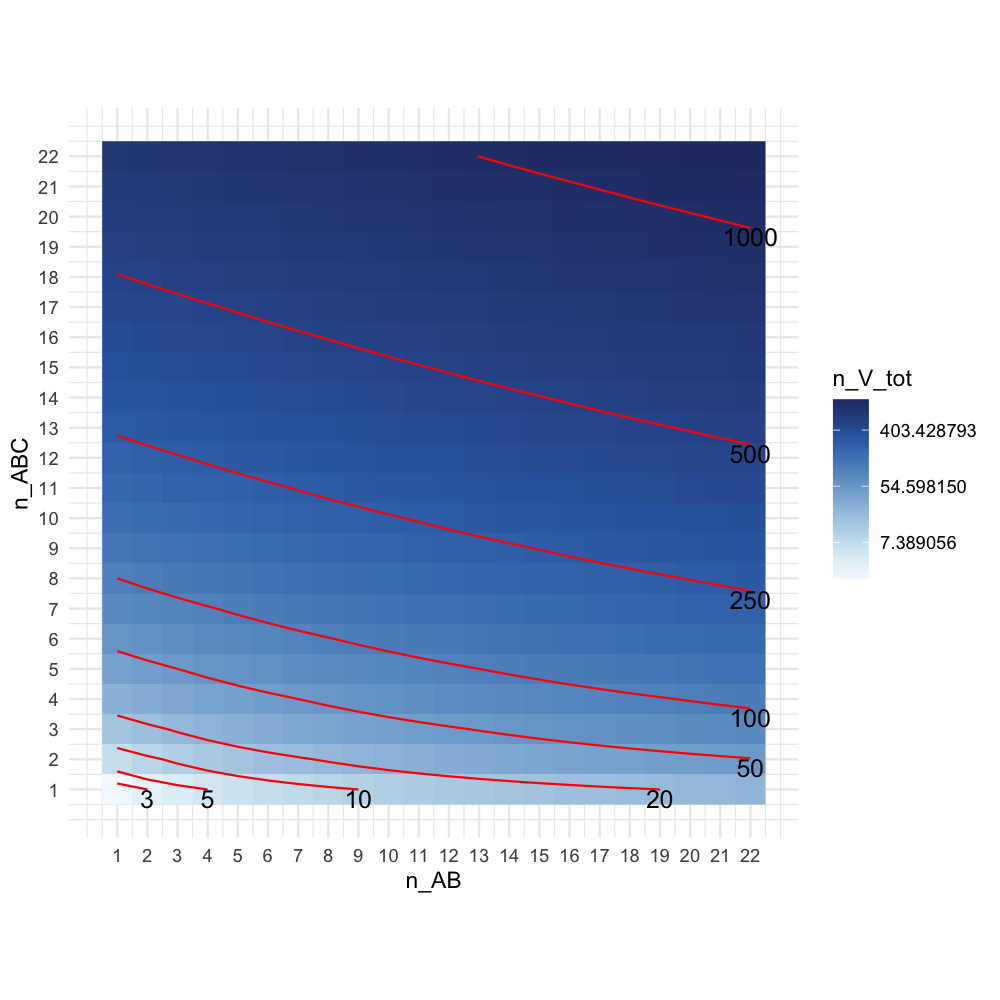

In [93]:
%%R -w 1000 -h 1000 -r 150

library(tidyverse)
library(directlabels)

vec_n_AB = 1:22
vec_n_ABC = vec_n_AB

tab_plt <- expand.grid(vec_n_AB, vec_n_ABC) %>%
    transmute(
        n_AB = Var1,
        n_ABC = Var2,
        n_V0 = n_AB*n_ABC,
        n_VM = n_ABC,
        n_V1_V2_V3 = 3*choose(n_ABC, 2),
        n_V_tot = n_V0+n_VM+n_V1_V2_V3
    )  
    
    
brks = c(3, 5, 10, 20, 50, 100, 250, 500, 1000)
tab_plt %>%
    ggplot() +
    geom_raster(aes(n_AB, n_ABC, fill = n_V_tot)) +
    geom_contour(aes(n_AB, n_ABC, z = n_V_tot), 
                 breaks = brks, color = 'red') +
    geom_dl(aes(n_AB, n_ABC, z = n_V_tot, label=..level..), 
            method="bottom.pieces", color = 'black',
             stat="contour", breaks = brks) +
    theme_minimal() +
    scale_y_continuous(breaks = vec_n_AB) +
    scale_x_continuous(breaks = vec_n_ABC) +
    coord_fixed() +
    colorspace::scale_fill_continuous_sequential(palette="Blues", trans = 'log')

In [101]:
%%R

tab_plt %>%
    filter(n_AB <=20, n_ABC <=5) %>%
    select(n_AB, n_ABC, n_V_tot) %>%
    pivot_wider(names_from = n_ABC, values_from = n_V_tot)

# A tibble: 20 × 6
    n_AB   `1`   `2`   `3`   `4`   `5`
   <int> <dbl> <dbl> <dbl> <dbl> <dbl>
 1     1     2     7    15    26    40
 2     2     3     9    18    30    45
 3     3     4    11    21    34    50
 4     4     5    13    24    38    55
 5     5     6    15    27    42    60
 6     6     7    17    30    46    65
 7     7     8    19    33    50    70
 8     8     9    21    36    54    75
 9     9    10    23    39    58    80
10    10    11    25    42    62    85
11    11    12    27    45    66    90
12    12    13    29    48    70    95
13    13    14    31    51    74   100
14    14    15    33    54    78   105
15    15    16    35    57    82   110
16    16    17    37    60    86   115
17    17    18    39    63    90   120
18    18    19    41    66    94   125
19    19    20    43    69    98   130
20    20    21    45    72   102   135


The marginal probability of the left site being equal to $V_0$:

$
\begin{align}
    &P(l=V_0)=\sum_{i\in (A_{V_{0}}\cup\,A_{L})}\pi_i 
\end{align}
$

Where $A_{V_0}$ is the set of starting states where both the left and right sites are in $V_0$ state (namely, states number 14 and 15), and $A_{L}$ is the set of starting states where the left site is $V_0$ and the right site is $not$ $V_0$ (states 9, 11 and 13).

And knowing that $P(X|Y)=\frac{P(X,Y)}{P(Y)}$, we can get the conditional probabilities, which will correspond to the first row of the transition probability matrix.

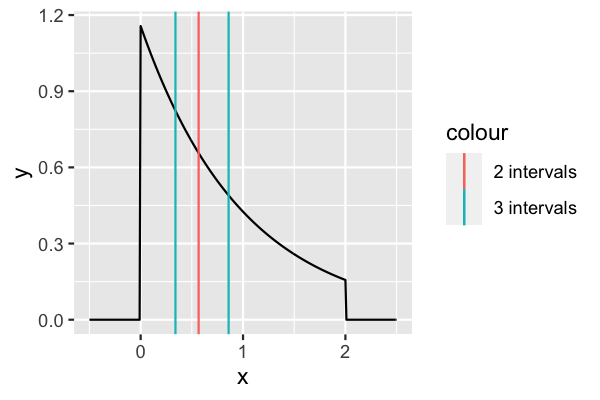

In [58]:
%%R -w 600 -h 400 -r 150

library(ReIns)

tibble(
    x = seq(-0.5, 2.5, 0.01),
    y = dtexp(x, 1, 2),
) %>%
ggplot() +
geom_line(aes(x, y)) +
geom_vline(aes(xintercept = qtexp(0.5, 1, 2), color = '2 intervals')) +
geom_vline(aes(xintercept = x, color = '3 intervals'),
          data = tibble(x = qtexp(c(1/3, 2/3), 1, 2)))

In [131]:
from scipy.stats import truncexpon
import matplotlib.pyplot as plt


In [132]:
b = 4.69
mean, var, skew, kurt = truncexpon.stats(b, moments='mvsk')

In [147]:
lower, upper, scale = 0, 2, 1
truncexpon.ppf([1/3, 2/3], b=(upper-lower)/scale, loc=lower, scale=scale)

array([0.33998861, 0.85906752])